In [117]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pandas as pd
import os
import emcee
import corner
from getdist import plots, gaussian_mixtures, MCSamples

# SNe Ia Data & MCMC

In [118]:
os.listdir()
os.listdir('Pantheon_SNeIa_dataset/')

['lcparam_DS17f.txt']

In [119]:
#binned Pantheon SNe Ia data
full_data = pd.read_csv('Pantheon_SNeIa_dataset/lcparam_DS17f.txt',sep=' ')

redshift = full_data['zcmb']
appmag = full_data['mb']
appmag_unc = full_data['dmb']

#absolute magnitude for Type 1a SNe
absmag = -19.25

#distance modulus = m - M
distmod = appmag - absmag
distmod.shape
distmod_unc = appmag_unc

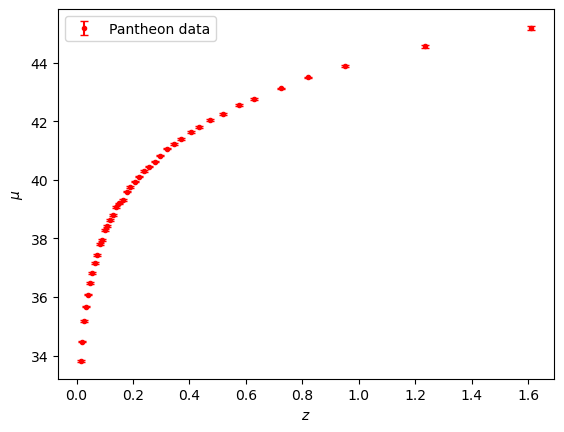

In [120]:
plt.figure()
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.show()

In [121]:
H0 = 70000 #Hubble param today in m/s/Mpc (in km/s/Mpc its 70)
ls = 299792458 #speed of light in m/s

def integrand(z,Omr0,Omm0,Oml0):
    res = 1./np.sqrt(Omr0*(1+z)**4 + Omm0*(1+z)**3 + Oml0)
    return res

def dL(z,Omr0,Omm0,Oml0):
    #luminosity distance in Mpc
    integr = integrate.quad(integrand, 0, z, args=(Omr0,Omm0,Oml0))
    return (1+z)*ls*integr[0]/H0

def dist_mod(lum_dist):
    res = 5.*np.log10(lum_dist) + 25.
    return res

def dLvect(z,Omr0,Omm0,Oml0):
    #luminosity distance in Mpc
    length = len(z)
    res = []
    for i in range(length):
        integr = integrate.quad(integrand, 0, z[i], args=(Omr0,Omm0,Oml0))
        res.append((1+z[i])*ls*integr[0]/H0)
    return res

In [122]:
dL(1,0.0006,0.3,0.69)
#dist_mod(dL(1,0.0006,0.3,0.69))


print(dL(1,0.0006,0.3,0.69),dL(2,0.0006,0.3,0.69))
print(dLvect([1,2],0.0006,0.3,0.69))

print(dist_mod(dL(1,0.0006,0.3,0.69)),dist_mod(dL(2,0.0006,0.3,0.69)))
print(dist_mod(dLvect([1,2],0.0006,0.3,0.69)))

6623.475569345691 15557.195417004756
[6623.475569345691, 15557.195417004756]
44.10542969379678 45.959656535022376
[44.10542969 45.95965654]


In [123]:
# Define the log_likelihood function
def log_likelihood(params):
    Omr0, Omm0, Oml0 = params
    theoretical_dm = dist_mod(dLvect(redshift, Omr0, Omm0, Oml0))
    return -0.5*np.sum(((distmod.values - theoretical_dm)/distmod_unc.values)**2 + np.log(2*np.pi*distmod_unc**2))

In [124]:
log_likelihood([0.006,0.25,0.65])

-1213.7183653631432

In [125]:
# Uniform log_prior
def log_prior(params):
    Omr0, Omm0, Oml0 = params
    if 0.0 <= Omr0 <= 0.001 and 0.0 <= Omm0 <= 1.0 and 0.0 <= Oml0 <= 1.0:
        return -np.log(0.001*1*1)
    return -np.inf

In [126]:
log_prior([0.006,0.25,0.65])

-inf

In [127]:
#Product, resp. sum in logarithm form of likelihood and prior
def log_sum(params):
    # Compute the log-prior
    lp = log_prior(params)
    if lp == -np.inf:
        # If the prior is zero (i.e. log is -infinity), return negative infinity
        return -np.inf
    
    # Compute the log-likelihood
    ll = log_likelihood(params)
    
    # Compute the log-posterior as the sum of the log-prior and log-likelihood
    return lp + ll

In [128]:
log_sum([0.006,0.25,0.65])

-inf

In [129]:
# Set the number of dimensions (i.e. the number of parameters)
ndim = 3

# Set the number of walkers
nwalkers = 10

# Define the range of values for each parameter
theta_min = [0, 0, 0]
theta_max = [0.001, 1, 1]

# Generate random starting positions for the walkers within the defined range
p0 = np.zeros((nwalkers, ndim))
for i in range(ndim):
    p0[:, i] = np.random.uniform(theta_min[i], theta_max[i], size=nwalkers)

# Initialize the sampler
#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_sum, moves=emcee.moves.GaussianMove(np.diag([0.00001,0.01,0.01])), args=())
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_sum, args=())

In [130]:
# Run the sampler for a specified number of iterations
n_iterations = 1000
sampler.run_mcmc(p0, n_iterations, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.92it/s]


State([[6.55053795e-04 3.14594254e-01 7.81261395e-01]
 [2.13922922e-04 3.06801356e-01 8.00191629e-01]
 [1.00008465e-04 3.33640528e-01 7.64204269e-01]
 [4.57042604e-04 3.20281037e-01 7.81636842e-01]
 [5.14961336e-05 3.16284932e-01 7.92363320e-01]
 [9.96962978e-04 3.25088405e-01 7.69139105e-01]
 [4.73193960e-04 3.21678574e-01 7.85850662e-01]
 [5.84911680e-04 3.15693244e-01 7.83618682e-01]
 [6.20846728e-04 3.11435631e-01 7.90353886e-01]
 [8.08396239e-04 2.93603560e-01 8.11923185e-01]], log_prob=[87.76242495 88.07107866 86.63387591 87.90269697 87.00433311 87.66761537
 86.12246987 88.25334176 88.31892613 86.9475724 ], blobs=None, random_state=('MT19937', array([3616205085,  168552887, 3599553883, 2805057970,  100501620,
        804205663,  429085651, 2740745915, 2483521008, 1733179197,
        994426162,  248000049, 1294937810, 3478404875, 3188136887,
       3138774419, 1323763429, 2121928085, 1459662121, 4252061628,
        672439944, 1776485817,  465118186,  525544574, 3978284736,
       

In [131]:
# Get the chain of samples produced by the sampler
#samples = sampler.chain[:, :, :].reshape((-1, ndim))
samples = sampler.chain[:, :, :]
print(sampler.chain[:,:,:].shape)

# Discard the first few samples as burn-in
burnin = 100
final_samples = samples[:,burnin:, :]
print(final_samples.shape)

(10, 1000, 3)
(10, 900, 3)


(9000, 3)


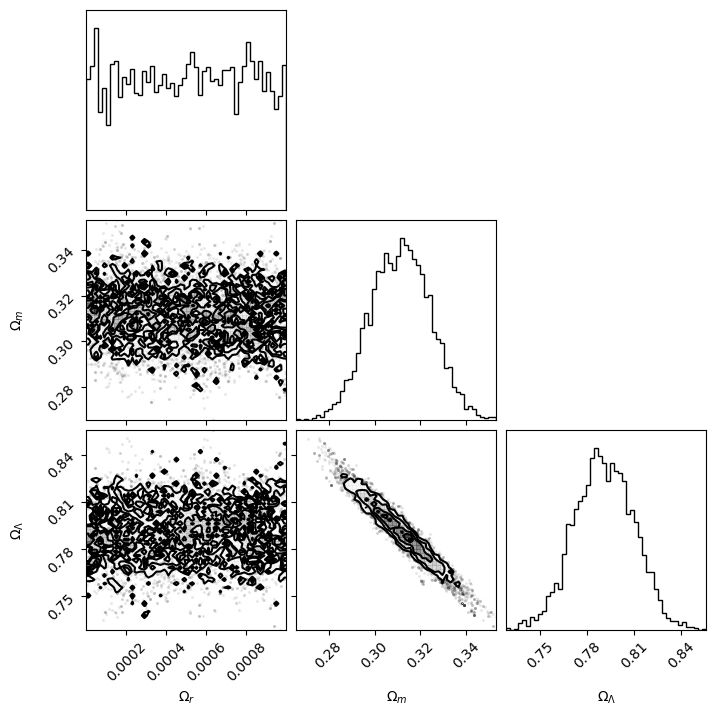

In [132]:
# Flatten the chain of samples
flat_samples = final_samples.reshape(-1, ndim)
print(flat_samples.shape)

# Plot the corner plot using the flattened samples
figure = corner.corner(flat_samples,bins=50, labels=['$\Omega_r$','$\Omega_m$', '$\Omega_\Lambda$'])

# Show the plot
plt.show()

Removed no burn in


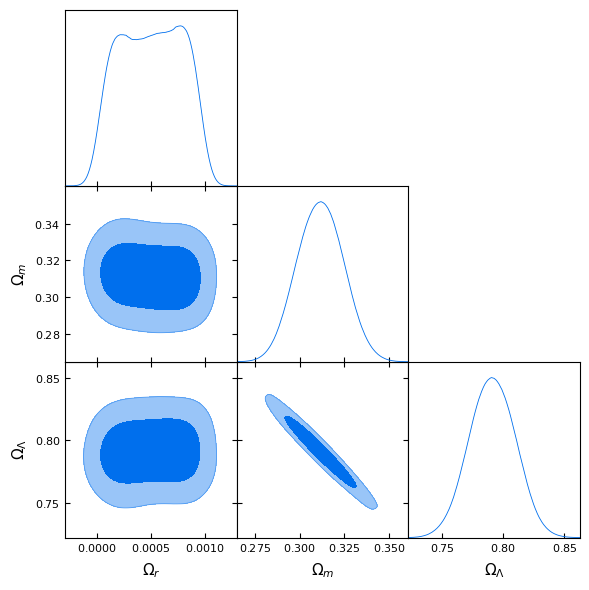

In [133]:
names = ['Omega_r','Omega_m', 'Omega_L']
labels =  ['\Omega_r','\Omega_m', '\Omega_\Lambda']
samples_new = MCSamples(samples=np.array(flat_samples),names=names,labels=labels,label='SNe Ia')
g = plots.get_subplot_plotter()
g.triangle_plot(samples_new, filled=True)

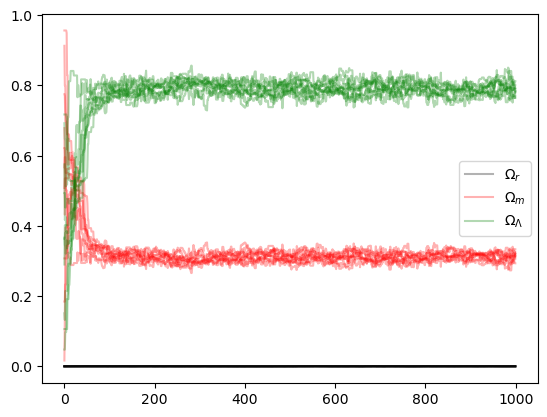

In [134]:
plt.figure()
plt.plot(samples[0,:,0].T, '-', color='k', alpha=0.3,label='$\Omega_r$')
plt.plot(samples[1:,:,0].T, '-', color='k', alpha=0.3)
plt.plot(samples[0,:,1].T, '-', color='r', alpha=0.3,label='$\Omega_m$')
plt.plot(samples[1:,:,1].T, '-', color='r', alpha=0.3)
plt.plot(samples[0,:,2].T, '-', color='g', alpha=0.3,label='$\Omega_\Lambda$')
plt.plot(samples[1:,:,2].T, '-', color='g', alpha=0.3)
plt.legend()
plt.show()

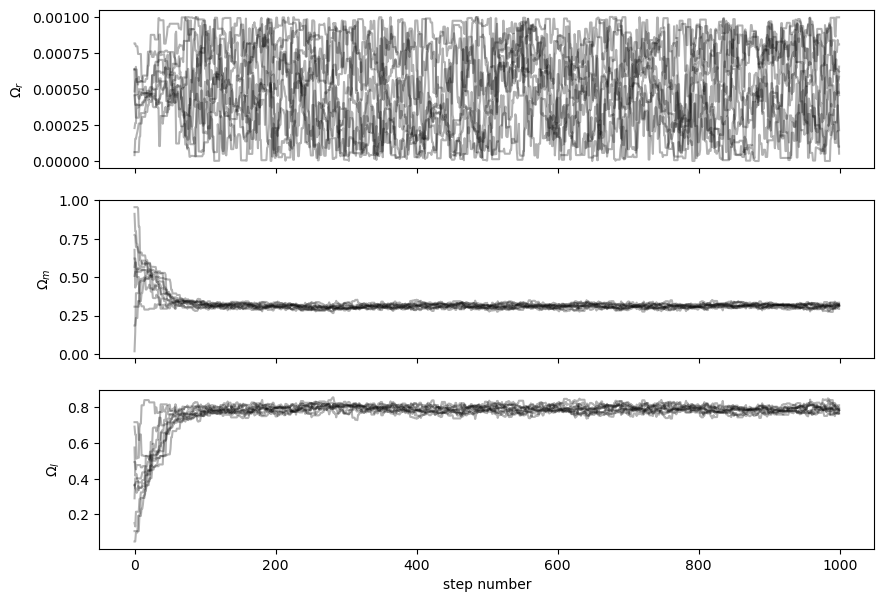

In [135]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$\Omega_r$", "$\Omega_m$", "$\Omega_l$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:,:,i].T, "k-", alpha=0.3)
    #ax.set_xlim(0, 10000)
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");

In [136]:
sampler.chain[:,:,0].T.shape

(1000, 10)

In [137]:
#mean and std dev of Om_r
m1 = np.mean(flat_samples[:,0])
std1 = np.std(flat_samples[:,0])
print('Mean of Om_r = ',m1)
print('Std dev of Om_r = ',std1)

#mean and std dev of Om_m
m2 = np.mean(flat_samples[:,1])
std2 = np.std(flat_samples[:,1])
print('Mean of Om_m = ',m2)
print('Std dev of Om_m = ',std2)

#mean and std dev of Om_l
m3 = np.mean(flat_samples[:,2])
std3 = np.std(flat_samples[:,2])
print('Mean of Om_l = ',m3)
print('Std dev of Om_l = ',std3)

Mean of Om_r =  0.0005016475210233538
Std dev of Om_r =  0.0002878716391660573
Mean of Om_m =  0.31145774017405775
Std dev of Om_m =  0.012933205652600305
Mean of Om_l =  0.7910028995668682
Std dev of Om_l =  0.01876878947749635


C:\Users\armin\AppData\Local\Temp\ipykernel_20532\4177855242.py:14: RuntimeWarning: divide by zero encountered in log10
  res = 5.*np.log10(lum_dist) + 25.


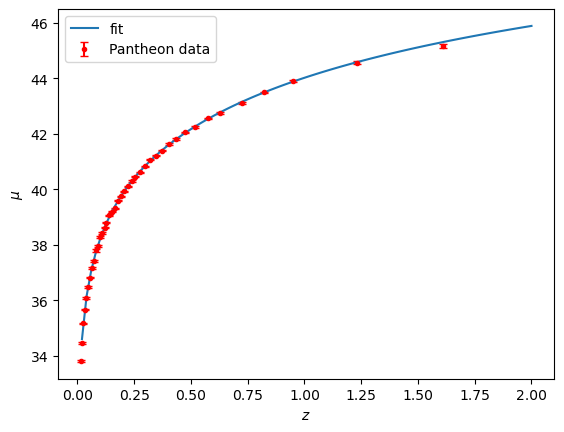

In [138]:
x = np.linspace(0,2,100)
y = dist_mod(dLvect(x,m1,m2,m3))

plt.figure()
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.plot(x,y,label='fit')
plt.plot
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.show()

In [139]:
BIC = ndim*np.log(np.size(redshift)) + 2*log_likelihood([m1,m2,m3])
print('BIC = ', BIC)

BIC =  173.88384937141834


# CC Data & MCMC

In [140]:
os.listdir()
os.listdir('CC_dataset/')

['CC_data.xlsx']

In [141]:
#CC data
full_data_CC = pd.read_excel('CC_dataset/CC_data.xlsx')

redshift_CC = full_data_CC['redshift']
Hub = full_data_CC['H(z)']
Hub_unc = full_data_CC['sigma']

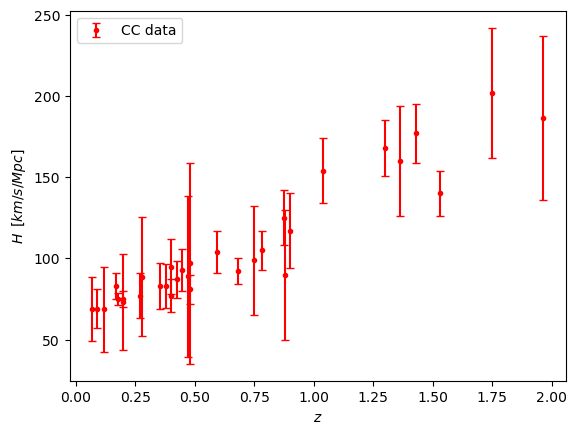

In [142]:
plt.figure()
plt.errorbar(redshift_CC, Hub, yerr=Hub_unc, capsize=3, fmt='r.', label='CC data')
plt.xlabel('$z$')
plt.ylabel('$H\,\,\,[km/s/Mpc]$')
plt.legend()
plt.show()

In [143]:
H0_av = 70
def Hubble(z,Omr0,Omm0,Oml0):
    res = H0_av*np.sqrt(Omr0*(1+z)**4 + Omm0*(1+z)**3 + Oml0)
    return res

In [144]:
# Define the log_likelihood function
def log_likelihood_CC(params):
    Omr0, Omm0, Oml0 = params
    theoretical_Hub = Hubble(redshift_CC, Omr0, Omm0, Oml0)
    return -0.5*np.sum(((Hub.values - theoretical_Hub)/Hub_unc.values)**2 + np.log(2*np.pi*Hub_unc.values**2))

In [145]:
# Uniform log_prior
def log_prior_CC(params):
    Omr0, Omm0, Oml0 = params
    if 0.0 <= Omr0 <= 0.001 and 0.0 <= Omm0 <= 1.0 and 0.0 <= Oml0 <= 1.0:
        return -np.log(0.001*1*1)
    return -np.inf

In [146]:
#Product, resp. sum in logarithm form of likelihood and prior
def log_sum_CC(params):
    # Compute the log-prior
    lp = log_prior_CC(params)
    if lp == -np.inf:
        # If the prior is zero (i.e. log is -infinity), return negative infinity
        return -np.inf
    
    # Compute the log-likelihood
    ll = log_likelihood_CC(params)
    
    # Compute the log-posterior as the sum of the log-prior and log-likelihood
    return lp + ll

In [147]:
# Set the number of dimensions (i.e. the number of parameters)
ndim = 3

# Set the number of walkers
nwalkers = 10

# Define the range of values for each parameter
theta_min = [0, 0, 0]
theta_max = [0.001, 1, 1]

# Generate random starting positions for the walkers within the defined range
p0 = np.zeros((nwalkers, ndim))
for i in range(ndim):
    p0[:, i] = np.random.uniform(theta_min[i], theta_max[i], size=nwalkers)

# Initialize the sampler
#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_sum, moves=emcee.moves.GaussianMove(np.diag([0.00001,0.01,0.01])), args=())
sampler_CC = emcee.EnsembleSampler(nwalkers, ndim, log_sum_CC, args=())

In [148]:
# Run the sampler for a specified number of iterations
n_iterations = 1000
sampler_CC.run_mcmc(p0, n_iterations, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 66.96it/s]


State([[6.86060792e-05 3.00563508e-01 7.02403908e-01]
 [7.13577818e-04 2.66845585e-01 6.67113538e-01]
 [6.57812777e-04 3.13965210e-01 6.45838930e-01]
 [3.00298745e-04 3.29140655e-01 5.72562866e-01]
 [9.83656589e-04 3.43703927e-01 4.96008996e-01]
 [5.89521535e-05 3.34318953e-01 5.71392397e-01]
 [6.51848439e-04 3.78726366e-01 5.77468276e-01]
 [5.11216908e-04 2.93893283e-01 6.82394448e-01]
 [4.64744880e-04 2.81850916e-01 6.90407037e-01]
 [3.12105963e-05 2.97560713e-01 6.92546048e-01]], log_prob=[-121.87163852 -122.49134898 -121.75204367 -121.88801657 -122.56987552
 -121.98806458 -125.23687787 -121.63988421 -121.74111251 -121.7233572 ], blobs=None, random_state=('MT19937', array([3616205085,  168552887, 3599553883, 2805057970,  100501620,
        804205663,  429085651, 2740745915, 2483521008, 1733179197,
        994426162,  248000049, 1294937810, 3478404875, 3188136887,
       3138774419, 1323763429, 2121928085, 1459662121, 4252061628,
        672439944, 1776485817,  465118186,  525544574,

In [149]:
# Get the chain of samples produced by the sampler
#samples = sampler.chain[:, :, :].reshape((-1, ndim))
samples_CC = sampler_CC.chain[:, :, :]
print(sampler_CC.chain[:,:,:].shape)

# Discard the first few samples as burn-in
burnin = 100
final_samples_CC = samples_CC[:,burnin:, :]
print(final_samples_CC.shape)

(10, 1000, 3)
(10, 900, 3)


(9000, 3)


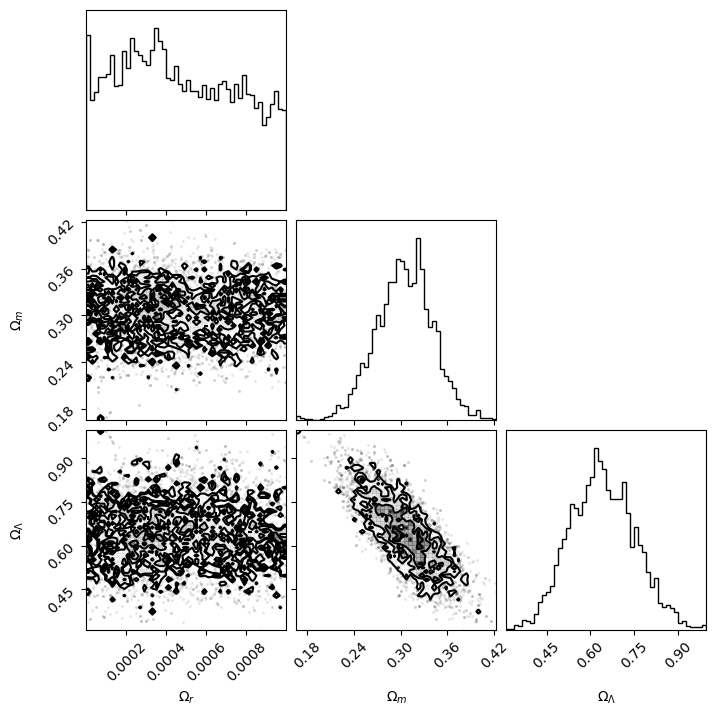

In [150]:
# Flatten the chain of samples
flat_samples_CC = final_samples_CC.reshape(-1, ndim)
print(flat_samples_CC.shape)

# Plot the corner plot using the flattened samples
figure_CC = corner.corner(flat_samples_CC,bins=50, labels=['$\Omega_r$','$\Omega_m$', '$\Omega_\Lambda$'])

# Show the plot
plt.show()

Removed no burn in


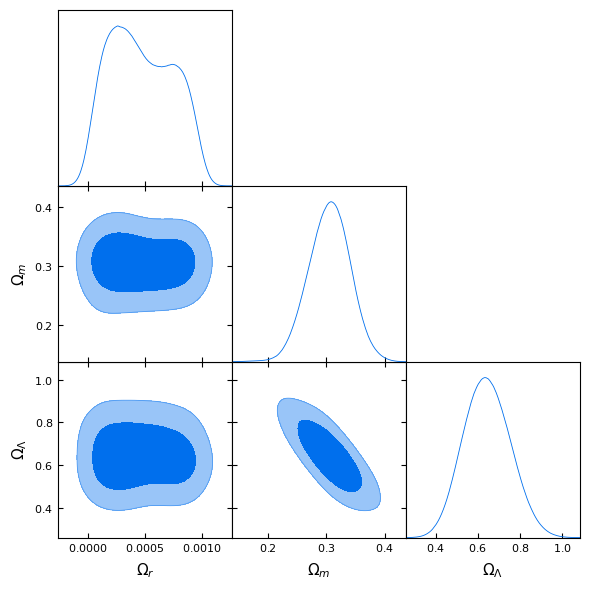

In [151]:
names = ['Omega_r','Omega_m', 'Omega_L']
labels =  ['\Omega_r','\Omega_m', '\Omega_\Lambda']
samples_new_CC = MCSamples(samples=np.array(flat_samples_CC),names=names,labels=labels,label='CC')
g_CC = plots.get_subplot_plotter()
g_CC.triangle_plot(samples_new_CC, filled=True)

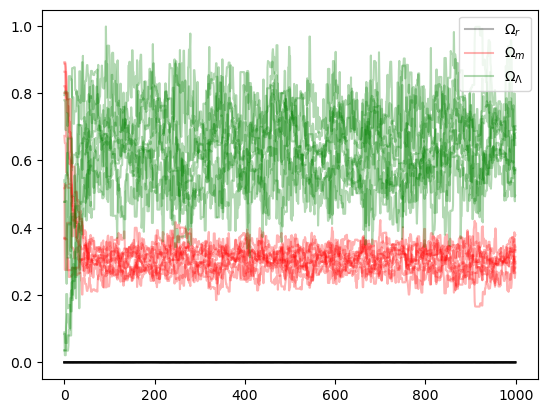

In [152]:
plt.figure()
plt.plot(samples_CC[0,:,0].T, '-', color='k', alpha=0.3,label='$\Omega_r$')
plt.plot(samples_CC[1:,:,0].T, '-', color='k', alpha=0.3)
plt.plot(samples_CC[0,:,1].T, '-', color='r', alpha=0.3,label='$\Omega_m$')
plt.plot(samples_CC[1:,:,1].T, '-', color='r', alpha=0.3)
plt.plot(samples_CC[0,:,2].T, '-', color='g', alpha=0.3,label='$\Omega_\Lambda$')
plt.plot(samples_CC[1:,:,2].T, '-', color='g', alpha=0.3)
plt.legend()
plt.show()

In [153]:
#mean and std dev of Om_r
m1_CC = np.mean(flat_samples_CC[:,0])
std1_CC = np.std(flat_samples_CC[:,0])
print('Mean of Om_r = ',m1_CC)
print('Std dev of Om_r = ',std1_CC)

#mean and std dev of Om_m
m2_CC = np.mean(flat_samples_CC[:,1])
std2_CC = np.std(flat_samples_CC[:,1])
print('Mean of Om_m = ',m2_CC)
print('Std dev of Om_m = ',std2_CC)

#mean and std dev of Om_l
m3_CC = np.mean(flat_samples_CC[:,2])
std3_CC = np.std(flat_samples_CC[:,2])
print('Mean of Om_l = ',m3_CC)
print('Std dev of Om_l = ',std3_CC)

Mean of Om_r =  0.0004675431688165756
Std dev of Om_r =  0.0002809213315249313
Mean of Om_m =  0.3049422799459067
Std dev of Om_m =  0.035510145676442034
Mean of Om_l =  0.6424436689108448
Std dev of Om_l =  0.1098897056469261


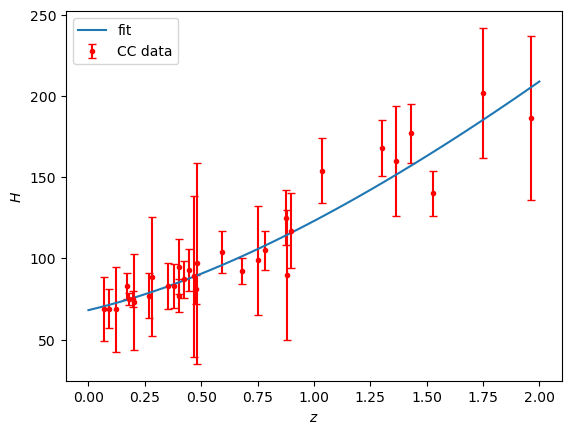

In [154]:
x_CC = np.linspace(0,2,100)
y_CC = Hubble(x,m1_CC,m2_CC,m3_CC)

plt.figure()
plt.errorbar(redshift_CC, Hub, yerr=Hub_unc, capsize=3, fmt='r.', label='CC data')
plt.plot(x_CC,y_CC,label='fit')
plt.plot
plt.xlabel('$z$')
plt.ylabel('$H$')
plt.legend()
plt.show()

# SNe Ia + CC

In [155]:
def log_sum_SNe_CC(params):
    lp = log_prior(params)
    if lp == -np.inf:
        # If the prior is zero (i.e. log is -infinity), return negative infinity
        return -np.inf
    
    # Compute the log-likelihood
    ll_SN = log_likelihood(params)
    ll_CC = log_likelihood_CC(params)
    
    # Compute the log-posterior as the sum of the log-prior and log-likelihood
    return lp + ll_SN + ll_CC

# Set the number of dimensions (i.e. the number of parameters)
ndim = 3

# Set the number of walkers
nwalkers = 10

# Define the range of values for each parameter
theta_min = [0, 0, 0]
theta_max = [0.001, 1, 1]

# Generate random starting positions for the walkers within the defined range
p0 = np.zeros((nwalkers, ndim))
for i in range(ndim):
    p0[:, i] = np.random.uniform(theta_min[i], theta_max[i], size=nwalkers)

# Initialize the sampler
#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_sum, moves=emcee.moves.GaussianMove(np.diag([0.00001,0.01,0.01])), args=())
sampler_SNe_CC = emcee.EnsembleSampler(nwalkers, ndim, log_sum_SNe_CC, args=())

In [156]:
n_iterations = 1000
sampler_SNe_CC.run_mcmc(p0, n_iterations, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.53it/s]


State([[8.52511390e-04 3.05672960e-01 8.02263711e-01]
 [7.62892246e-04 3.10344341e-01 7.90404262e-01]
 [6.88070936e-04 2.94142255e-01 8.21204707e-01]
 [2.64431225e-04 2.91925519e-01 8.16603680e-01]
 [3.23242555e-04 3.05568112e-01 7.92962367e-01]
 [5.01657971e-04 2.88276175e-01 8.29514074e-01]
 [4.75455638e-04 2.91742941e-01 8.20747608e-01]
 [1.86926881e-04 3.05713354e-01 7.99047423e-01]
 [3.39357396e-04 3.09034900e-01 7.92890554e-01]
 [7.30507089e-04 3.06989755e-01 8.01612596e-01]], log_prob=[-43.41697634 -43.03518433 -44.58726766 -43.89453801 -43.7094957
 -45.22963764 -43.98185466 -42.97454564 -42.99568639 -43.64851653], blobs=None, random_state=('MT19937', array([3616205085,  168552887, 3599553883, 2805057970,  100501620,
        804205663,  429085651, 2740745915, 2483521008, 1733179197,
        994426162,  248000049, 1294937810, 3478404875, 3188136887,
       3138774419, 1323763429, 2121928085, 1459662121, 4252061628,
        672439944, 1776485817,  465118186,  525544574, 3978284736

In [157]:
# Get the chain of samples produced by the sampler
#samples = sampler.chain[:, :, :].reshape((-1, ndim))
samples_SNe_CC = sampler_SNe_CC.chain[:, :, :]
print(sampler_SNe_CC.chain[:,:,:].shape)

# Discard the first few samples as burn-in
burnin = 100
final_samples_SNe_CC = samples_SNe_CC[:,burnin:, :]
print(final_samples_SNe_CC.shape)

(10, 1000, 3)
(10, 900, 3)


(9000, 3)


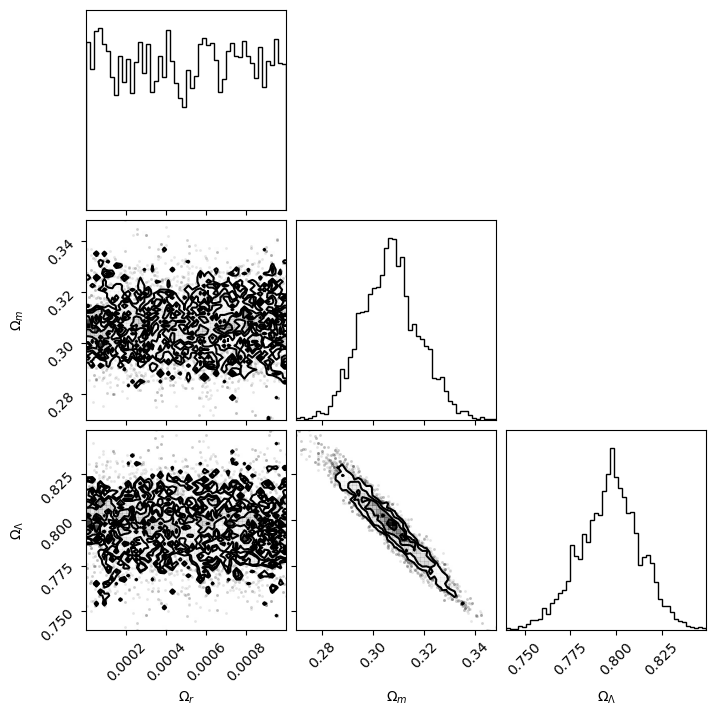

In [158]:
# Flatten the chain of samples
flat_samples_SNe_CC = final_samples_SNe_CC.reshape(-1, ndim)
print(flat_samples_SNe_CC.shape)

# Plot the corner plot using the flattened samples
figure_SNe_CC = corner.corner(flat_samples_SNe_CC,bins=50, labels=['$\Omega_r$','$\Omega_m$', '$\Omega_\Lambda$'])

# Show the plot
plt.show()

Removed no burn in


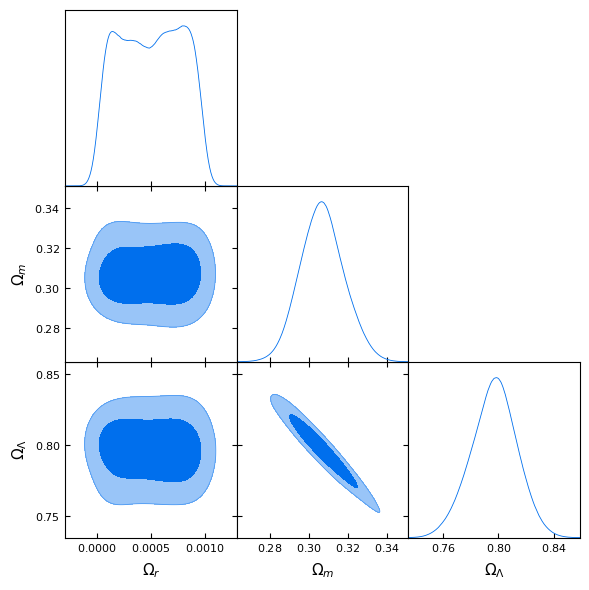

In [159]:
names = ['Omega_r','Omega_m', 'Omega_L']
labels =  ['\Omega_r','\Omega_m', '\Omega_\Lambda']
samples_new_SNe_CC = MCSamples(samples=np.array(flat_samples_SNe_CC),names=names,labels=labels, label='CC + SNe Ia')
g_SNe_CC = plots.get_subplot_plotter()
g_SNe_CC.triangle_plot(samples_new_SNe_CC, filled=True)

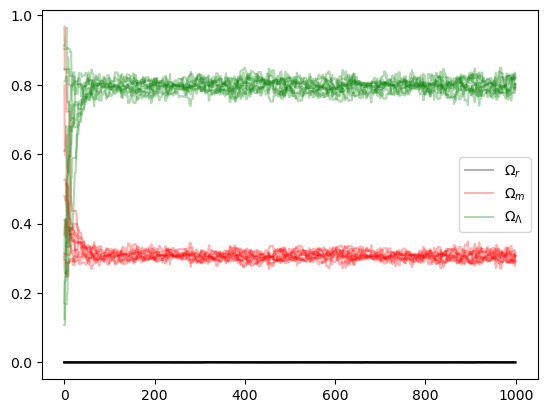

In [160]:
plt.figure()
plt.plot(samples_SNe_CC[0,:,0].T, '-', color='k', alpha=0.3,label='$\Omega_r$')
plt.plot(samples_SNe_CC[1:,:,0].T, '-', color='k', alpha=0.3)
plt.plot(samples_SNe_CC[0,:,1].T, '-', color='r', alpha=0.3,label='$\Omega_m$')
plt.plot(samples_SNe_CC[1:,:,1].T, '-', color='r', alpha=0.3)
plt.plot(samples_SNe_CC[0,:,2].T, '-', color='g', alpha=0.3,label='$\Omega_\Lambda$')
plt.plot(samples_SNe_CC[1:,:,2].T, '-', color='g', alpha=0.3)
plt.legend()
plt.show()

In [161]:
#mean and std dev of Om_r
m1_SNe_CC = np.mean(flat_samples_SNe_CC[:,0])
std1_SNe_CC = np.std(flat_samples_SNe_CC[:,0])
print('Mean of Om_r = ',m1_SNe_CC)
print('Std dev of Om_r = ',std1_SNe_CC)

#mean and std dev of Om_m
m2_SNe_CC = np.mean(flat_samples_SNe_CC[:,1])
std2_SNe_CC = np.std(flat_samples_SNe_CC[:,1])
print('Mean of Om_m = ',m2_SNe_CC)
print('Std dev of Om_m = ',std2_SNe_CC)

#mean and std dev of Om_l
m3_SNe_CC = np.mean(flat_samples_SNe_CC[:,2])
std3_SNe_CC = np.std(flat_samples_SNe_CC[:,2])
print('Mean of Om_l = ',m3_SNe_CC)
print('Std dev of Om_l = ',std3_SNe_CC)

Mean of Om_r =  0.000499433100608669
Std dev of Om_r =  0.0002927826503962077
Mean of Om_m =  0.30689450445072847
Std dev of Om_m =  0.011262326372386356
Mean of Om_l =  0.7967880356529039
Std dev of Om_l =  0.016583637267007095


C:\Users\armin\AppData\Local\Temp\ipykernel_20532\4177855242.py:14: RuntimeWarning: divide by zero encountered in log10
  res = 5.*np.log10(lum_dist) + 25.


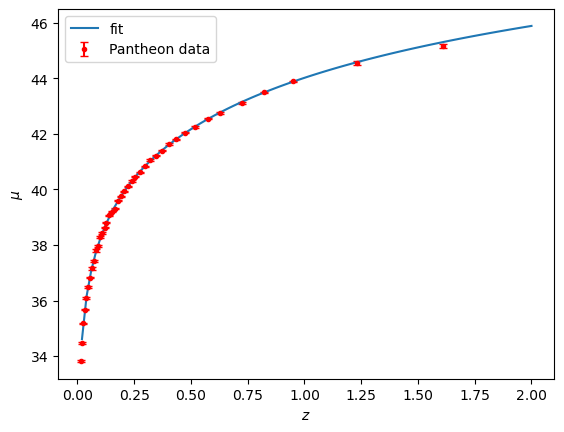

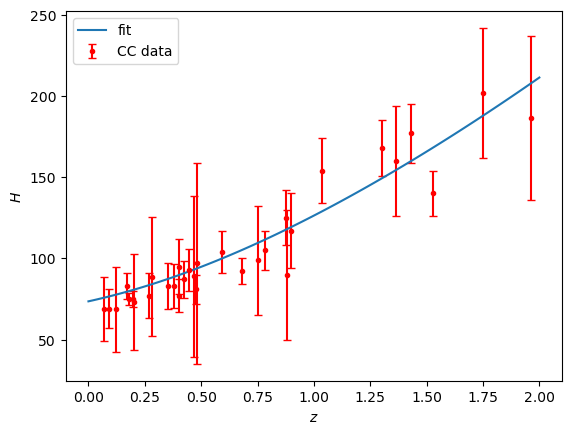

In [162]:
x_SNe_CC = np.linspace(0,2,100)
y_tot_SN = dist_mod(dLvect(x_SNe_CC,m1_SNe_CC,m2_SNe_CC,m3_SNe_CC))
y_tot_CC = Hubble(x,m1_SNe_CC,m2_SNe_CC,m3_SNe_CC)

plt.figure()
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.plot(x_SNe_CC,y_tot_SN,label='fit')
plt.plot
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(redshift_CC, Hub, yerr=Hub_unc, capsize=3, fmt='r.', label='CC data')
plt.plot(x_SNe_CC,y_tot_CC,label='fit')
plt.plot
plt.xlabel('$z$')
plt.ylabel('$H$')
plt.legend()
plt.show()

# Comparison

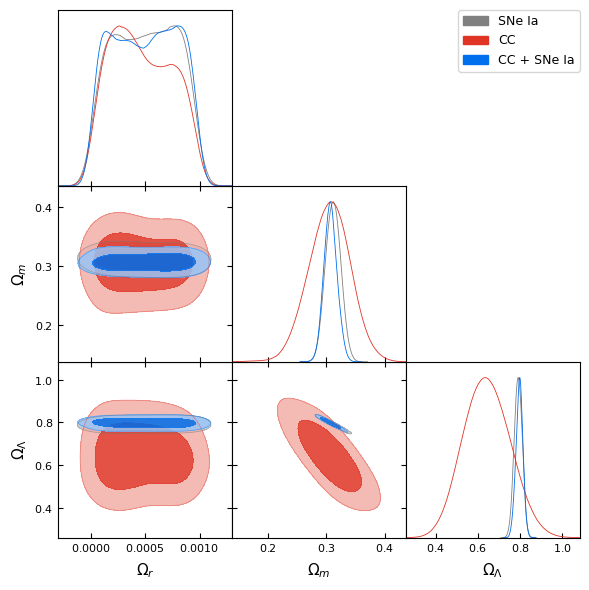

In [190]:
names = ['Omega_r','Omega_m', 'Omega_L']
labels =  ['\Omega_r','\Omega_m', '\Omega_\Lambda']
g_comp = plots.get_subplot_plotter()
g_comp.triangle_plot([samples_new,samples_new_CC,samples_new_SNe_CC], filled=True)

# CMB Distance Priors

In [164]:
ls_av = 299792.458 #lightspeed in km/s
z_CMB = 1089

#data
R = 1.7661
la = 301.7293
v_obs = np.array([R,la])
#print(v_obs)

#covariance matrix
C = 10**(-8)*np.array([[33483.54, -44417.15],[-44417.15, 4245661.67]])
C_inv = np.linalg.inv(C)
#print(C_inv)

In [165]:
def Comov_dist(params):
    Omr0, Omm0, Oml0 = params
    res = integrate.quad(integrand, 0, z_CMB, args=(Omr0,Omm0,Oml0))[0]*ls_av/H0_av
    return res

def Integr_Sound_hor(z,Omr0,Omm0,Oml0):
    res = 1./np.sqrt((1 + 660/(1+z))*(Omr0*(1+z)**4 + Omm0*(1+z)**3 + Oml0))
    return res

def Sound_hor(params):
    Omr0, Omm0, Oml0 = params
    res = integrate.quad(Integr_Sound_hor, z_CMB, np.inf, args=(Omr0,Omm0,Oml0))[0]*ls_av/(np.sqrt(3)*H0_av)
    return res

def Dist_priors(params):
    Omr0, Omm0, Oml0 = params
    R_theo = np.sqrt(Omm0)*H0_av*Comov_dist(params)/ls_av #for k not equal 0 need to take S_k(r) instead of just comov dist.!!
    la_theo = np.pi*Comov_dist(params)/Sound_hor(params) #""!!
    v_theo = np.array([R_theo,la_theo])
    return v_theo

In [166]:
v_theo_test = Dist_priors([0.00005,0.25,0.68])
#print(v_theo_test)

In [167]:
def log_likelihood_CMB(params):
    Omr0, Omm0, Oml0 = params
    v_theo = Dist_priors([Omr0, Omm0, Oml0])
    return -0.5*np.matmul((v_theo-v_obs).transpose(),np.matmul(C_inv,v_theo-v_obs))

def log_sum_CMB(params):
    # Compute the log-prior
    lp = log_prior(params)
    if lp == -np.inf:
        # If the prior is zero (i.e. log is -infinity), return negative infinity
        return -np.inf
    
    # Compute the log-likelihood
    ll = log_likelihood_CMB(params)
    
    # Compute the log-posterior as the sum of the log-prior and log-likelihood
    return lp + ll

In [168]:
#np.matmul((v_theo_test-v_obs).transpose(),np.matmul(C_inv,v_theo_test-v_obs))

In [169]:
# Set the number of dimensions (i.e. the number of parameters)
ndim = 3

# Set the number of walkers
nwalkers = 10

# Define the range of values for each parameter
theta_min = [0, 0, 0]
theta_max = [0.001, 1, 1]

# Generate random starting positions for the walkers within the defined range
p0 = np.zeros((nwalkers, ndim))
for i in range(ndim):
    p0[:, i] = np.random.uniform(theta_min[i], theta_max[i], size=nwalkers)

# Initialize the sampler
#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_sum, moves=emcee.moves.GaussianMove(np.diag([0.00001,0.01,0.01])), args=())
sampler_CMB = emcee.EnsembleSampler(nwalkers, ndim, log_sum_CMB, args=())

In [170]:
n_iterations = 1000
sampler_CMB.run_mcmc(p0, n_iterations, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.76it/s]


State([[9.99065857e-05 3.50956111e-01 6.52220772e-01]
 [1.62800056e-04 5.88601313e-01 9.91605175e-01]
 [1.51679694e-04 5.54106890e-01 8.96108837e-01]
 [1.32627534e-04 4.68939189e-01 8.60064420e-01]
 [1.47728231e-04 5.32356859e-01 8.98126447e-01]
 [1.41247772e-04 4.90635632e-01 9.59599651e-01]
 [1.40397960e-04 4.84343643e-01 9.87699296e-01]
 [1.16302771e-04 3.97607173e-01 8.28637813e-01]
 [1.33686518e-04 4.75308180e-01 8.52677989e-01]
 [3.07250581e-05 1.02255752e-01 2.38136214e-01]], log_prob=[5.96240315 6.67019656 6.43052509 6.8726337  6.371997   6.6176046
 6.50978414 6.58262728 6.84469861 5.76566496], blobs=None, random_state=('MT19937', array([3616205085,  168552887, 3599553883, 2805057970,  100501620,
        804205663,  429085651, 2740745915, 2483521008, 1733179197,
        994426162,  248000049, 1294937810, 3478404875, 3188136887,
       3138774419, 1323763429, 2121928085, 1459662121, 4252061628,
        672439944, 1776485817,  465118186,  525544574, 3978284736,
        929577659,

In [171]:
# Get the chain of samples produced by the sampler
#samples = sampler.chain[:, :, :].reshape((-1, ndim))
samples_CMB = sampler_CMB.chain[:, :, :]
print(sampler_CMB.chain[:,:,:].shape)

# Discard the first few samples as burn-in
burnin = 100
final_samples_CMB = samples_CMB[:,burnin:, :]
print(final_samples_CMB.shape)

(10, 1000, 3)
(10, 900, 3)


(9000, 3)


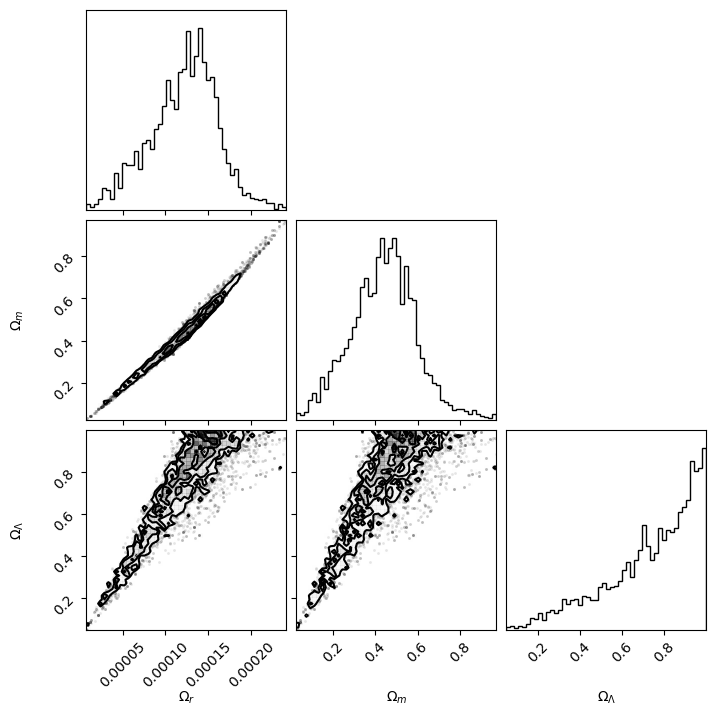

In [172]:
# Flatten the chain of samples
flat_samples_CMB = final_samples_CMB.reshape(-1, ndim)
print(flat_samples_CMB.shape)

# Plot the corner plot using the flattened samples
figure_CMB = corner.corner(flat_samples_CMB,bins=50, labels=['$\Omega_r$','$\Omega_m$', '$\Omega_\Lambda$'])

# Show the plot
plt.show()

Removed no burn in


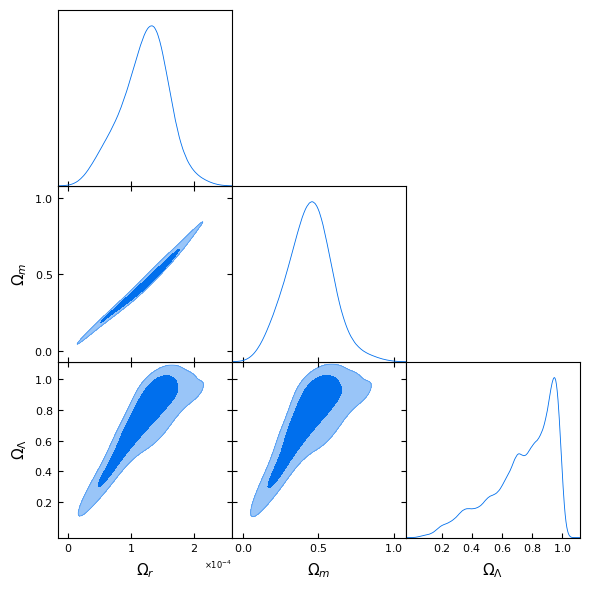

In [173]:
names = ['Omega_r','Omega_m', 'Omega_L']
labels =  ['\Omega_r','\Omega_m', '\Omega_\Lambda']
samples_new_CMB = MCSamples(samples=np.array(flat_samples_CMB),names=names,labels=labels, label='CMB')
g_CMB = plots.get_subplot_plotter()
g_CMB.triangle_plot(samples_new_CMB, filled=True)

# SNe Ia + CC + CMB

In [174]:
def log_sum_tot(params):
    lp = log_prior(params)
    if lp == -np.inf:
        # If the prior is zero (i.e. log is -infinity), return negative infinity
        return -np.inf
    
    # Compute the log-likelihood
    ll_SN = log_likelihood(params)
    ll_CC = log_likelihood_CC(params)
    ll_CMB = log_likelihood_CMB(params)
    
    # Compute the log-posterior as the sum of the log-prior and log-likelihood
    return lp + ll_SN + ll_CC + ll_CMB

# Set the number of dimensions (i.e. the number of parameters)
ndim = 3

# Set the number of walkers
nwalkers = 10

# Define the range of values for each parameter
theta_min = [0, 0, 0]
theta_max = [0.001, 1, 1]

# Generate random starting positions for the walkers within the defined range
p0 = np.zeros((nwalkers, ndim))
for i in range(ndim):
    p0[:, i] = np.random.uniform(theta_min[i], theta_max[i], size=nwalkers)

# Initialize the sampler
#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_sum, moves=emcee.moves.GaussianMove(np.diag([0.00001,0.01,0.01])), args=())
sampler_tot = emcee.EnsembleSampler(nwalkers, ndim, log_sum_tot, args=())

In [175]:
n_iterations = 1000
sampler_tot.run_mcmc(p0, n_iterations, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:19<00:00, 12.58it/s]


State([[9.89180012e-05 3.28902462e-01 7.65072420e-01]
 [1.00087428e-04 3.35525172e-01 7.51746204e-01]
 [9.50607942e-05 3.04654120e-01 8.00047188e-01]
 [9.63603407e-05 3.14005028e-01 7.86739895e-01]
 [9.45349647e-05 3.04231708e-01 7.99031098e-01]
 [9.60749069e-05 3.12389391e-01 7.97630930e-01]
 [9.83090186e-05 3.24616585e-01 7.80106114e-01]
 [9.72351484e-05 3.19864131e-01 7.73227741e-01]
 [9.64079680e-05 3.14448854e-01 7.86488396e-01]
 [9.94744706e-05 3.30165406e-01 7.74316245e-01]], log_prob=[-45.65429632 -47.27527539 -45.74504336 -44.93194475 -45.71548521
 -47.7196326  -47.13951034 -45.59833177 -45.0016166  -48.11571308], blobs=None, random_state=('MT19937', array([3616205085,  168552887, 3599553883, 2805057970,  100501620,
        804205663,  429085651, 2740745915, 2483521008, 1733179197,
        994426162,  248000049, 1294937810, 3478404875, 3188136887,
       3138774419, 1323763429, 2121928085, 1459662121, 4252061628,
        672439944, 1776485817,  465118186,  525544574, 397828473

In [176]:
# Get the chain of samples produced by the sampler
#samples = sampler.chain[:, :, :].reshape((-1, ndim))
samples_tot = sampler_tot.chain[:, :, :]
print(sampler_tot.chain[:,:,:].shape)

# Discard the first few samples as burn-in
burnin = 100
final_samples_tot = samples_tot[:,burnin:, :]
print(final_samples_tot.shape)

(10, 1000, 3)
(10, 900, 3)


(9000, 3)


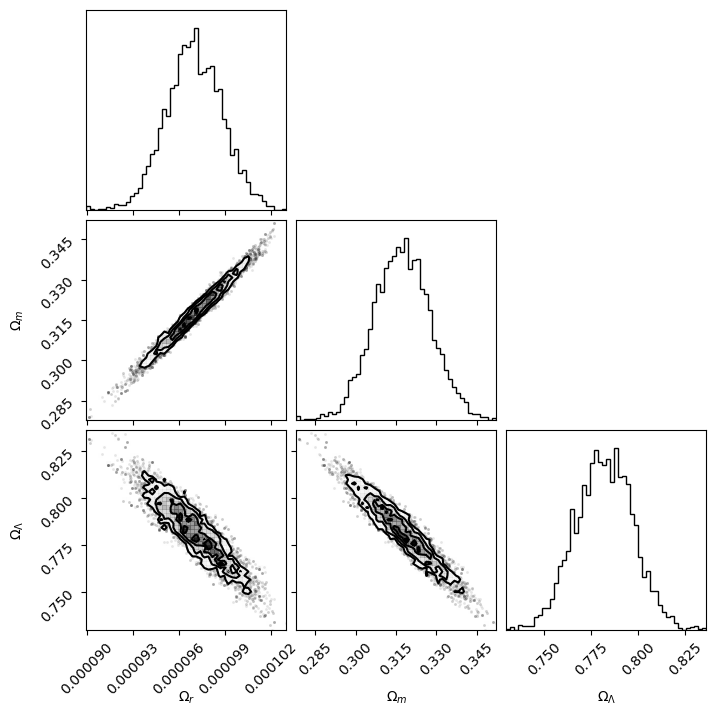

In [177]:
# Flatten the chain of samples
flat_samples_tot = final_samples_tot.reshape(-1, ndim)
print(flat_samples_tot.shape)

# Plot the corner plot using the flattened samples
figure_tot = corner.corner(flat_samples_tot,bins=50, labels=['$\Omega_r$','$\Omega_m$', '$\Omega_\Lambda$'])

# Show the plot
plt.show()

Removed no burn in


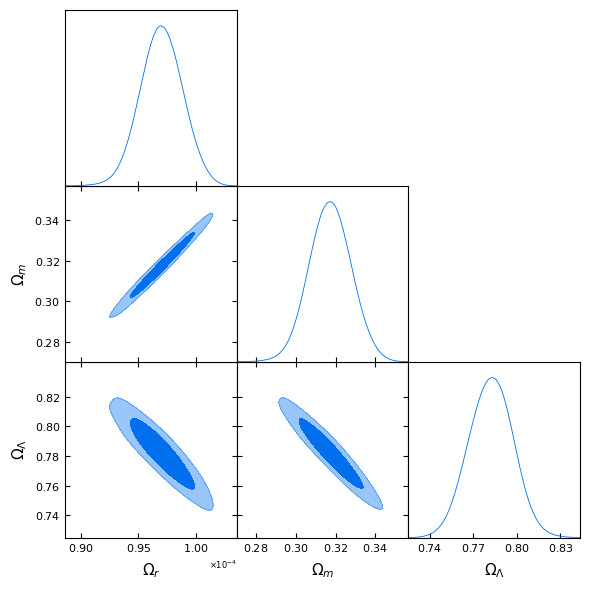

In [178]:
names = ['Omega_r','Omega_m', 'Omega_L']
labels =  ['\Omega_r','\Omega_m', '\Omega_\Lambda']
samples_new_tot = MCSamples(samples=np.array(flat_samples_tot),names=names,labels=labels, label='SNe Ia + CC + CMB')
g_tot = plots.get_subplot_plotter()
g_tot.triangle_plot(samples_new_tot, filled=True)

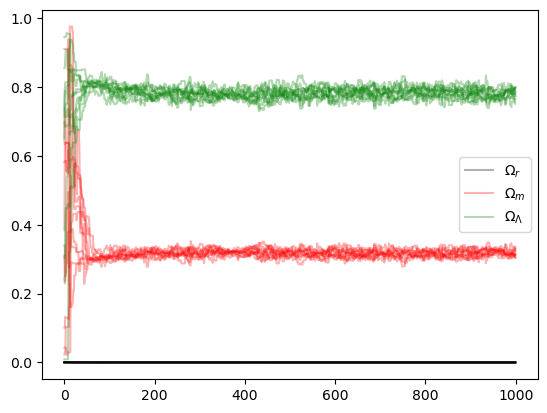

In [179]:
plt.figure()
plt.plot(samples_tot[0,:,0].T, '-', color='k', alpha=0.3,label='$\Omega_r$')
plt.plot(samples_tot[1:,:,0].T, '-', color='k', alpha=0.3)
plt.plot(samples_tot[0,:,1].T, '-', color='r', alpha=0.3,label='$\Omega_m$')
plt.plot(samples_tot[1:,:,1].T, '-', color='r', alpha=0.3)
plt.plot(samples_tot[0,:,2].T, '-', color='g', alpha=0.3,label='$\Omega_\Lambda$')
plt.plot(samples_tot[1:,:,2].T, '-', color='g', alpha=0.3)
plt.legend()
plt.show()

In [180]:
#mean and std dev of Om_r
m1_tot = np.mean(flat_samples_tot[:,0])
std1_tot = np.std(flat_samples_tot[:,0])
print('Mean of Om_r = ',m1_tot)
print('Std dev of Om_r = ',std1_tot)

#mean and std dev of Om_m
m2_tot = np.mean(flat_samples_tot[:,1])
std2_tot = np.std(flat_samples_tot[:,1])
print('Mean of Om_m = ',m2_tot)
print('Std dev of Om_m = ',std2_tot)

#mean and std dev of Om_l
m3_tot = np.mean(flat_samples_tot[:,2])
std3_tot = np.std(flat_samples_tot[:,2])
print('Mean of Om_l = ',m3_tot)
print('Std dev of Om_l = ',std3_tot)

Mean of Om_r =  9.699357450422158e-05
Std dev of Om_r =  1.8229138453984054e-06
Mean of Om_m =  0.31731397601107003
Std dev of Om_m =  0.010456656885205489
Mean of Om_l =  0.7821061975138176
Std dev of Om_l =  0.01516114251192823


C:\Users\armin\AppData\Local\Temp\ipykernel_20532\4177855242.py:14: RuntimeWarning: divide by zero encountered in log10
  res = 5.*np.log10(lum_dist) + 25.


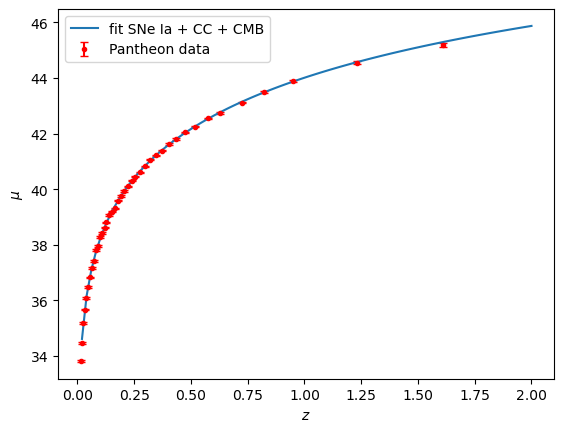

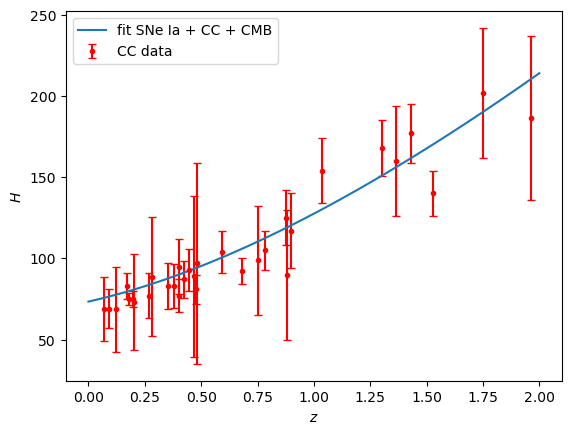

In [182]:
#fits
x_tot = np.linspace(0,2,100)
y_tot_SN = dist_mod(dLvect(x_tot,m1_tot,m2_tot,m3_tot))
y_tot_CC = Hubble(x_tot,m1_tot,m2_tot,m3_tot)

plt.figure()
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.plot(x_tot,y_tot_SN,label='fit SNe Ia + CC + CMB')
plt.plot
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(redshift_CC, Hub, yerr=Hub_unc, capsize=3, fmt='r.', label='CC data')
plt.plot(x_tot,y_tot_CC,label='fit SNe Ia + CC + CMB')
plt.plot
plt.xlabel('$z$')
plt.ylabel('$H$')
plt.legend()
plt.show()

In [188]:
#best CMB distance prior values determined via MCMC
v_best = Dist_priors([m1_tot,m2_tot,m3_tot])
print('fitted distance priors:', v_best)
print('observed distance priors:', v_obs)

fitted distance priors: [  1.7341383  301.74558596]
observed distance priors: [  1.7661 301.7293]


# Comparison

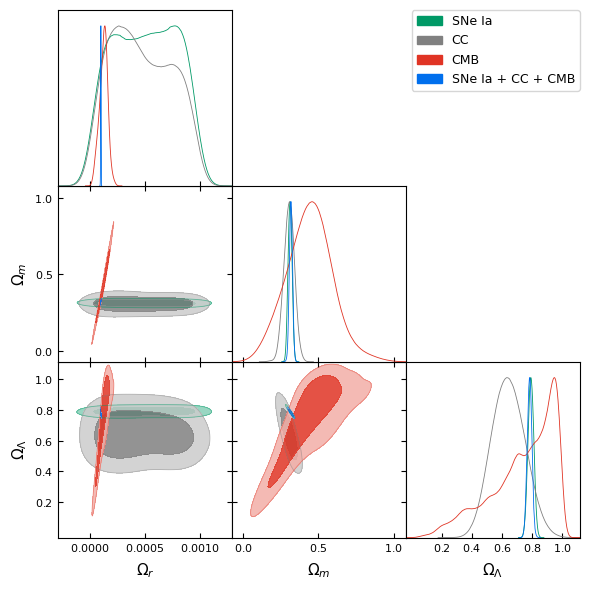

In [194]:
names = ['Omega_r','Omega_m', 'Omega_L']
labels =  ['\Omega_r','\Omega_m', '\Omega_\Lambda']
g_comp_tot = plots.get_subplot_plotter()
g_comp_tot.triangle_plot([samples_new,samples_new_CC,samples_new_CMB,samples_new_tot], filled=True)